Loading annotations... This might take a moment.
loading annotations into memory...
Done (t=18.89s)
creating index...
index created!
Annotations loaded successfully.

--- Image Count per Class in the Training Set ---
person          | Found in  64115 images
bicycle         | Found in   3252 images
car             | Found in  12251 images
motorcycle      | Found in   3502 images
bus             | Found in   3952 images
truck           | Found in   6127 images
traffic light   | Found in   4139 images
stop sign       | Found in   1734 images

--- Displaying a Random Example ---
Found 71536 total unique images containing one or more of the needed classes.


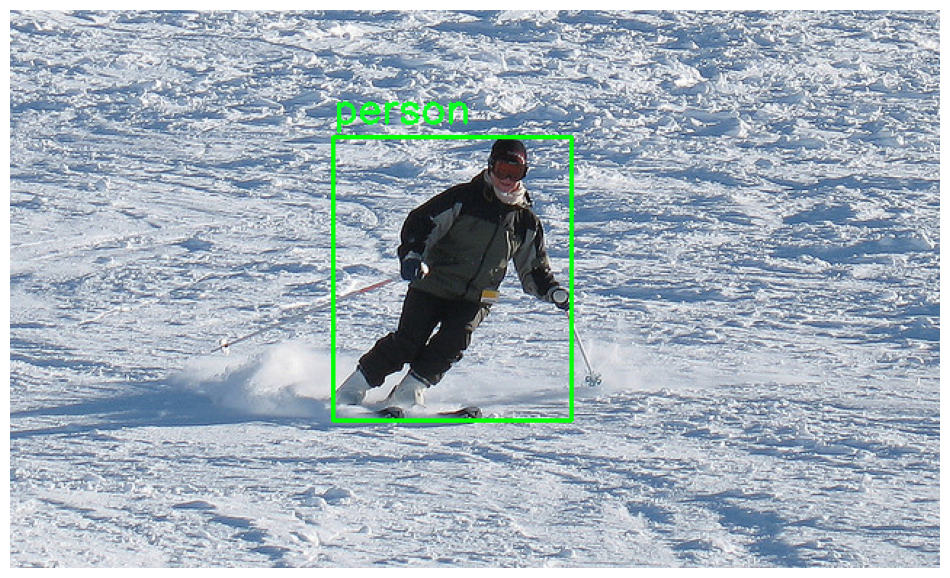

In [6]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

# --- Setup Paths ---
data_dir = 'coco2017'
data_type = 'train2017'
ann_file = os.path.join(data_dir, 'annotations', f'instances_{data_type}.json')
img_dir = os.path.join(data_dir, data_type)

# --- Initialize COCO API ---
print("Loading annotations... This might take a moment.")
coco = COCO(ann_file)
print("Annotations loaded successfully.")

# --- Define the 8 classes needed for the project ---
needed_classes = [
    'person', 'bicycle', 'car', 'motorcycle', 'bus', 
    'truck', 'traffic light', 'stop sign'
]

# ===================================================================
# PART 1: COUNT IMAGES PER CLASS 📊
# ===================================================================
print("\n--- Image Count per Class in the Training Set ---")
for class_name in needed_classes:
    cat_ids_for_class = coco.getCatIds(catNms=[class_name])
    img_ids_for_class = coco.getImgIds(catIds=cat_ids_for_class)
    print(f"{class_name:<15} | Found in {len(img_ids_for_class):>6} images")

# ===================================================================
# PART 2: VISUALIZE A RANDOM EXAMPLE (Corrected Logic) 🖼️
# ===================================================================
print("\n--- Displaying a Random Example ---")

# First, get the category IDs for all needed classes
cat_ids = coco.getCatIds(catNms=needed_classes)

# To get images with ANY class, we get image IDs for each class and combine them.
# A 'set' is used to automatically handle duplicates.
img_id_set = set()
for cat_id in cat_ids:
    img_ids_for_class = coco.getImgIds(catIds=[cat_id])
    img_id_set.update(img_ids_for_class)

# Convert the set of unique image IDs back to a list
img_ids = list(img_id_set)

print(f"Found {len(img_ids)} total unique images containing one or more of the needed classes.")

# Select a random image from this list
random_img_id = random.choice(img_ids)
img_info = coco.loadImgs(random_img_id)[0]
img_path = os.path.join(img_dir, img_info['file_name'])

# Load the image and its relevant annotations
image = cv2.imread(img_path)
ann_ids = coco.getAnnIds(imgIds=img_info['id'], catIds=cat_ids, iscrowd=None)
anns = coco.loadAnns(ann_ids)

# Draw the bounding boxes and labels on the image
for ann in anns:
    bbox = ann['bbox']
    cat_id = ann['category_id']
    cat_name = coco.loadCats(cat_id)[0]['name']
    
    x, y, w, h = [int(i) for i in bbox]
    
    cv2.rectangle(image, (x, y), (x + w, y + h), color=(0, 255, 0), thickness=2)
    cv2.putText(image, cat_name, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

# Display the final image
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 12))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

In [10]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, applications

# --- Define Model Parameters ---
IMG_SIZE = 640
NUM_CLASSES = 8
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

def build_model(input_shape, num_classes):
    """
    Builds the TrafficVision model and returns the final model and a reference to the backbone.
    """
    input_tensor = layers.Input(shape=input_shape)
    
    # 1. Create the backbone as a separate Keras Model object
    backbone = applications.EfficientNetV2M(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    
    # Set the backbone to be trainable (we'll freeze it in the next step)
    backbone.trainable = True
    
    # 2. Pass the input tensor through the backbone
    x = backbone(input_tensor)
    
    # --- 3. Simplified Detection Head ---
    # Classification head
    class_head = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    class_head = layers.Conv2D(num_classes, (1, 1), name='classification_output')(class_head)
    
    # Bounding box regression head
    bbox_head = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    bbox_head = layers.Conv2D(4, (1, 1), name='regression_output')(bbox_head)
    
    # 4. Create the final model
    model = models.Model(
        inputs=input_tensor,
        outputs=[class_head, bbox_head]
    )
    
    # Return both the complete model and the reference to the backbone
    return model, backbone

# Build the model and get the direct reference to the backbone
traffic_vision_model, backbone_ref = build_model(INPUT_SHAPE, NUM_CLASSES)

# Print a summary of the model's architecture
traffic_vision_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 640, 640, 3)]        0         []                            
                                                                                                  
 efficientnetv2-m (Function  (None, 20, 20, 1280)         5315038   ['input_3[0][0]']             
 al)                                                      8                                       
                                                                                                  
 conv2d_2 (Conv2D)           (None, 20, 20, 256)          2949376   ['efficientnetv2-m[0][0]']    
                                                                                                  
 conv2d_3 (Conv2D)           (None, 20, 20, 256)          2949376   ['efficientnetv2-m[0][0]

In [11]:
import tensorflow as tf
from tensorflow import keras

# --- Transfer Learning Strategy: Freeze the Backbone ---
# [cite_start]This implements the first phase of the training strategy mentioned in the proposal[cite: 120, 121].
# We use the direct reference to the backbone object to freeze its weights.
backbone_ref.trainable = False
print(f"Backbone '{backbone_ref.name}' has been frozen. Trainable status: {backbone_ref.trainable}")

# --- Loss Functions ---
# [cite_start]The proposal specifies two different loss functions for the two outputs[cite: 118].

# 1. Focal Loss (for Classification)
# [cite_start]A custom implementation to address class imbalance as required by the proposal[cite: 118].
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1. - 1e-7)
    pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    loss = -alpha * tf.pow(1. - pt, gamma) * tf.math.log(pt)
    return tf.reduce_mean(loss)

# 2. Smooth L1 Loss (for Bounding Box Regression)
# [cite_start]Keras provides this as the Huber loss, which is required by the proposal[cite: 118].
smooth_l1_loss = keras.losses.Huber()

# --- Optimizer ---
# [cite_start]The proposal specifies the Adam optimizer with an initial learning rate of 1e-4[cite: 125].
optimizer = keras.optimizers.Adam(learning_rate=1e-4)

# --- Compile the Model ---
# We assign the correct loss function to each of the model's named outputs.
traffic_vision_model.compile(
    optimizer=optimizer,
    loss={
        'classification_output': focal_loss,
        'regression_output': smooth_l1_loss
    }
)
print("\nModel compiled successfully.")

# --- Callbacks ---
# These tools help manage the training process as outlined in the proposal.

# [cite_start]Stops training if validation loss doesn't improve for 10 epochs[cite: 123].
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# [cite_start]Reduces the learning rate if training plateaus[cite: 125].
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5
)

# [cite_start]Saves the best version of the model during training[cite: 129].
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='traffic_vision_best.keras',
    save_best_only=True,
    monitor='val_loss'
)

callbacks_list = [early_stopping, reduce_lr, model_checkpoint]
print("\nCallbacks are ready.")

Backbone 'efficientnetv2-m' has been frozen. Trainable status: False

Model compiled successfully.

Callbacks are ready.


In [14]:
import numpy as np
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow import keras
from pycocotools.coco import COCO
import os
import cv2

# --- Corrected Helper Functions ---

def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1. - 1e-7)
    pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    loss = -alpha * tf.pow(1. - pt, gamma) * tf.math.log(pt)
    return tf.reduce_mean(loss)

def data_generator(coco_train, coco_val, img_ids, needed_classes, batch_size):
    """
    Yields batches of images and labels. Now handles both train and val coco objects.
    """
    cat_ids = coco_train.getCatIds(catNms=needed_classes)
    while True:
        random.shuffle(img_ids)
        for i in range(0, len(img_ids), batch_size):
            batch_img_ids = img_ids[i:i+batch_size]
            batch_images = []
            batch_labels_class = []
            batch_labels_bbox = []
            
            for img_id in batch_img_ids:
                # --- THIS IS THE FIX ---
                # Try to load from the training set first. If it fails, load from validation.
                try:
                    img_info = coco_train.loadImgs(img_id)[0]
                    img_dir = os.path.join(data_dir, 'train2017')
                    ann_ids = coco_train.getAnnIds(imgIds=img_id, catIds=cat_ids, iscrowd=None)
                    anns = coco_train.loadAnns(ann_ids)
                except KeyError:
                    img_info = coco_val.loadImgs(img_id)[0]
                    img_dir = os.path.join(data_dir, 'val2017')
                    ann_ids = coco_val.getAnnIds(imgIds=img_id, catIds=cat_ids, iscrowd=None)
                    anns = coco_val.loadAnns(ann_ids)

                img_path = os.path.join(img_dir, img_info['file_name'])
                
                image = cv2.imread(img_path)
                image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
                image = image / 255.0
                batch_images.append(image)
                
                # TODO: This is the critical part you must implement.
                placeholder_class_label = np.zeros((20, 20, NUM_CLASSES))
                placeholder_bbox_label = np.zeros((20, 20, 4))
                
                batch_labels_class.append(placeholder_class_label)
                batch_labels_bbox.append(placeholder_bbox_label)

            yield np.array(batch_images), {
                'classification_output': np.array(batch_labels_class),
                'regression_output': np.array(batch_labels_bbox)
            }

# --- 1. Combine All Data for K-Fold ---
print("Combining train and validation data for K-Fold splitting...")
coco_train = COCO(os.path.join(data_dir, 'annotations', 'instances_train2017.json'))
coco_val = COCO(os.path.join(data_dir, 'annotations', 'instances_val2017.json'))

train_cat_ids = coco_train.getCatIds(catNms=needed_classes)
train_img_id_set = set()
for cat_id in train_cat_ids:
    train_img_id_set.update(coco_train.getImgIds(catIds=[cat_id]))

val_cat_ids = coco_val.getCatIds(catNms=needed_classes)
val_img_id_set = set()
for cat_id in val_cat_ids:
    val_img_id_set.update(coco_val.getImgIds(catIds=[cat_id]))

all_img_ids = np.array(list(train_img_id_set.union(val_img_id_set)))
print(f"Combined dataset has {len(all_img_ids)} total unique images.")

# --- 2. Setup K-Fold Splitter ---
k = 5
kfold = KFold(n_splits=k, shuffle=True, random_state=42)
fold_scores = []

# --- 3. The K-Fold Training Loop ---
for fold, (train_indices, val_indices) in enumerate(kfold.split(all_img_ids)):
    print("-" * 60)
    print(f"--- STARTING FOLD {fold + 1}/{k} ---")
    
    model_fold, backbone_fold = build_model(INPUT_SHAPE, NUM_CLASSES)
    backbone_fold.trainable = False
    model_fold.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), 
                       loss={'classification_output': focal_loss, 'regression_output': keras.losses.Huber()})
    
    fold_train_ids = all_img_ids[train_indices].tolist()
    fold_val_ids = all_img_ids[val_indices].tolist()
    
    # --- Create data generators, now passing BOTH coco objects ---
    train_generator_fold = data_generator(coco_train, coco_val, fold_train_ids, needed_classes, batch_size=16)
    val_generator_fold = data_generator(coco_train, coco_val, fold_val_ids, needed_classes, batch_size=16)
    
    print(f"Training on {len(fold_train_ids)} images, validating on {len(fold_val_ids)} images...")
    steps_per_epoch = len(fold_train_ids) // 16
    validation_steps = len(fold_val_ids) // 16

    history_fold = model_fold.fit(
        train_generator_fold,
        steps_per_epoch=steps_per_epoch,
        epochs=10,
        callbacks=callbacks_list,
        validation_data=val_generator_fold,
        validation_steps=validation_steps,
        verbose=1
    )
    
    best_val_loss = min(history_fold.history['val_loss'])
    fold_scores.append(best_val_loss)
    print(f"\nBest Validation Loss for Fold {fold + 1}: {best_val_loss}\n")

# --- 4. Print Final Results ---
print("-" * 60)
print("--- K-FOLD CROSS-VALIDATION COMPLETE ---")
print(f"Scores for each fold (best val_loss): {fold_scores}")
print(f"Average Validation Loss: {np.mean(fold_scores)}")
print(f"Standard Deviation of Loss: {np.std(fold_scores)}")

Combining train and validation data for K-Fold splitting...
loading annotations into memory...
Done (t=69.50s)
creating index...
index created!
loading annotations into memory...
Done (t=0.89s)
creating index...
index created!
Combined dataset has 74564 total unique images.
------------------------------------------------------------
--- STARTING FOLD 1/5 ---
Training on 59651 images, validating on 14913 images...
Epoch 1/10
  62/3728 [..............................] - ETA: 14:33:51 - loss: 0.0960 - classification_output_loss: 0.0423 - regression_output_loss: 0.0538

KeyboardInterrupt: 